In [1]:
import spectromancer as sp
import corv

from astropy.table import Table, join, vstack
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../')
import WD_models

plt.style.use('stefan.mplstyle')

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da
We could not find the pickled WD models
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
source_id = 3121385658671190784
obs = sp.Observation('../data/observations/')

In [3]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')

In [4]:
obj = Table.read('../data/raw/elbadry.csv')
obj = obj[obj['wd_source_id'] == source_id]

In [5]:
from astroquery.gaia import Gaia

def make_physical_photometry(catalog):
    # convert gaia flux into physical units (see documentation)
    catalog['wd_phot_g_mean_flux'] = catalog['wd_phot_g_mean_flux'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
    catalog['wd_phot_bp_mean_flux'] = catalog['wd_phot_bp_mean_flux'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
    catalog['wd_phot_rp_mean_flux'] = catalog['wd_phot_rp_mean_flux'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

    # then convert the errors
    catalog['wd_phot_g_mean_flux_error'] = catalog['wd_phot_g_mean_flux_error'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
    catalog['wd_phot_bp_mean_flux_error'] = catalog['wd_phot_bp_mean_flux_error'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
    catalog['wd_phot_rp_mean_flux_error'] = catalog['wd_phot_rp_mean_flux_error'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

    # finally convert the magnitude uncertainties
    catalog['wd_e_gmag'] = catalog['wd_phot_g_mean_flux_error'] / (1.09 * catalog['wd_phot_g_mean_flux'])
    catalog['wd_e_bpmag'] = catalog['wd_phot_bp_mean_flux_error'] / (1.09 * catalog['wd_phot_bp_mean_flux'])
    catalog['wd_e_rpmag'] = catalog['wd_phot_rp_mean_flux_error'] / (1.09 * catalog['wd_phot_rp_mean_flux'])
    return catalog

def get_bailerjones(catalog):
    ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
            FROM gaiadr3.gaia_source as gaia
            JOIN external.gaiaedr3_distance as dist
            ON gaia.source_id = dist.source_id      
            WHERE gaia.source_id = {}""".format(catalog['ms_source_id'][0])
    gaia_d1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()
    gaia_d1.rename_column('source_id', 'ms_source_id')
    catalog = join(catalog, gaia_d1, keys = 'ms_source_id')
    return catalog

def radius_from_cmd(catalog):
    newton_G = 6.674e-11
    mass_sun = 1.9884e30
    radius_sun = 6.957e8

    model = WD_models.load_model(low_mass_model='Bedard2020',
                                middle_mass_model='Bedard2020',
                                high_mass_model='ONe',
                                atm_type='H',
                                HR_bands=('bp3-rp3', 'G3'))

    bp3_rp3 = catalog['wd_phot_bp_mean_mag'] - catalog['wd_phot_rp_mean_mag']
    G3 = catalog['wd_phot_g_mean_mag'] - 5 * np.log10(catalog['r_med_geo']) + 5
    logg = model['HR_to_logg'](bp3_rp3, G3)
    mass = model['HR_to_mass'](bp3_rp3, G3)

    catalog['cmd_radius'] = np.sqrt((newton_G * mass * mass_sun) / (10**logg/100)) / radius_sun
    return catalog

def get_msrv(catalog):
    stardats = []
    iters = (len(catalog)+2000) // 2000
    for i in range(iters):
            ADQL_CODE1 = """SELECT source_id, radial_velocity, radial_velocity_error
            FROM gaiadr3.gaia_source
            WHERE source_id = {}""".format(catalog['ms_source_id'][0])
            stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
    gaia_d1 = vstack(stardats)
    gaia_d1.rename_columns(['SOURCE_ID', 'radial_velocity', 'radial_velocity_error'], ['ms_source_id', 'ms_rv', 'ms_erv'])
    catalog = join(catalog, gaia_d1, keys = 'ms_source_id')
    return catalog

obj = make_physical_photometry(obj)
obj = get_bailerjones(obj)
obj = radius_from_cmd(obj)
obj = get_msrv(obj)

obj = join(obj, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3')

In [6]:
test1 = Table.read('../data/ADP.2022-02-21T05_02_49.595.fits')
test2 = Table.read('../data/ADP.2022-02-21T05_02_49.605.fits')

wave1 = test1['WAVE'].data[0]
flux1 = test1['FLUX'].data[0]
ivar1 = 1 / (test1['ERR'].data[0] + 1e-6)
mask1 = np.all([test1['ERR'].data[0] != 0, flux1 > 0, flux1 < 10], axis=0)

wave2 = test2['WAVE'].data[0]
flux2 = test2['FLUX'].data[0]
ivar2 = 1 / (test2['ERR'].data[0] + 1e-6)
mask2 = np.all([test2['ERR'].data[0] != 0, flux2 > 0, flux2 < 10], axis=0)

wave = np.concatenate([wave1[mask1], wave2[mask2]])
flux = np.concatenate([flux1[mask1], flux2[mask2]])
ivar = np.concatenate([ivar1[mask1], ivar2[mask2]])
uves_spec = sp.Spectrum(wave, flux, ivar)

Text(0, 0.5, 'Flux $[erg/s/cm^2/\\AA]$')

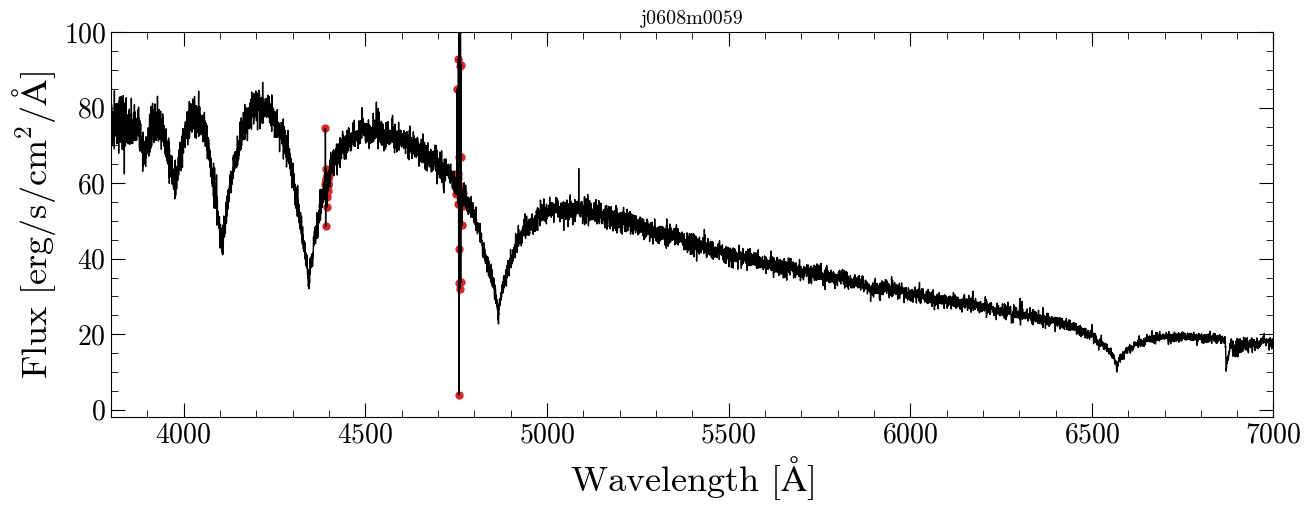

In [7]:
target = obs.targets[0]
name, wave, flux, ivar = target.name, target.spectrum.wave, target.spectrum.flux, target.spectrum.ivar
bad = ((wave > 4750) & (wave < 4770)) | ((wave > 4390) & (wave < 4400))

plt.figure(figsize = (15, 5))
plt.title(name)
plt.plot(wave, flux, lw = 1, color = 'k')
plt.scatter(wave[bad], flux[bad], lw = 1, color = 'C3')
plt.ylim(-2, 100)
plt.xlim(3800, 7000)
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/s/cm^2/\AA]$')

In [8]:
clean_sp = sp.Spectrum(wave[~bad], flux[~bad], ivar[~bad]) + uves_spec

# (197.2823117074479, 3.248938346250327)
corvmodel = corv.models.make_warwick_da_model(names = ['a','b'])
rv, e_rv, redchi, param_res = clean_sp.fit_rv(corvmodel)
rv, e_rv

(199.4885163413612, 7.307263971604598)

findfont: Font family 'Helvetica' not found.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


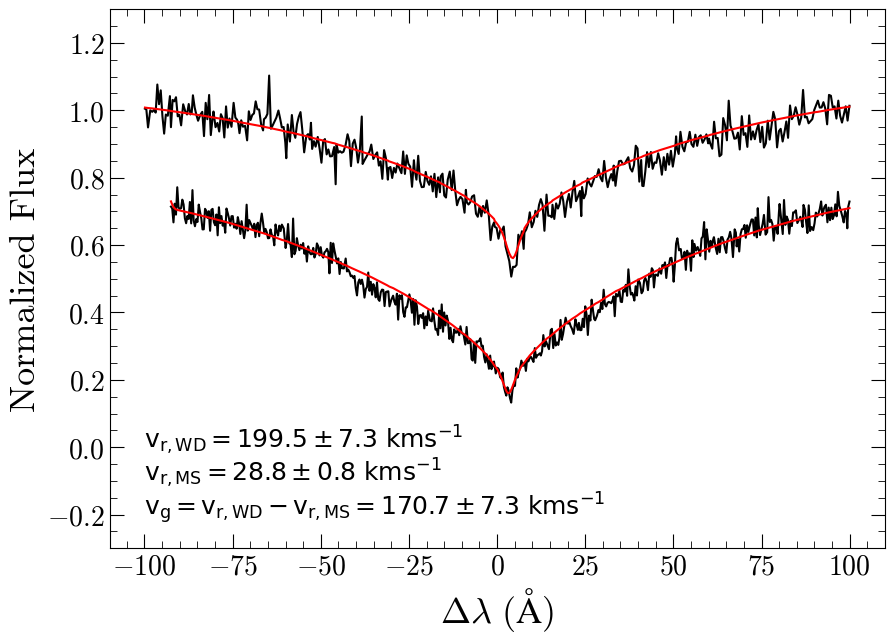

In [9]:
hfont = {'fontname':'Helvetica'}

fig = corv.utils.lineplot(wave[~bad], flux[~bad], ivar[~bad], corvmodel, param_res.params, gap = 0.3, printparams = False,
             figsize = (10, 7))
plt.text(-100,0, r'$v_{{r, WD}} = %2.1f \pm %2.1f$ $km s^{-1}$' % (rv, e_rv), fontsize=18, **hfont)
plt.text(-100,-0.1, r'$v_{{r, MS}} = %2.1f \pm %2.1f$ $km s^{-1}$' % (obj['ms_rv'][0], obj['ms_erv'][0]), fontsize=18, **hfont)
plt.text(-100,-0.2, r'$v_{{g}} = v_{{r, WD}} - v_{{r, MS}} = %2.1f \pm %2.1f$ $km s^{-1}$' % (rv - obj['ms_rv'][0], np.sqrt(e_rv**2 + obj['ms_erv'][0]**2)), 
                fontsize=18, **hfont)
fig.savefig('../figures/example_corvfit.pdf')

In [10]:
import sys
sys.path.append('../')
import corecomposition as cc
from corecomposition import interpolator
import corner
import pickle
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

distance = obj['r_med_geo'][0]
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
photomet = np.array([obj['wd_phot_g_mean_mag'], obj['wd_phot_bp_mean_mag'], obj['wd_phot_rp_mean_mag']]).T[0]
e_photomet = np.array([obj['wd_e_gmag'], obj['wd_e_bpmag'], obj['wd_e_rpmag']]).T[0]
initial_guess = np.array([obj['Teff'], obj['cmd_radius']]).T[0]

teff_constraint = np.array([obj['Teff'], obj['e_Teff']]).T[0]
if np.all(teff_constraint == np.array([0,0])):
    teff_constraint = np.array([None, None])
    initial_guess = np.array([10000, obj['cmd_radius'][0]])

print(photomet, e_photomet, distance, initial_guess, teff_constraint)

gaia_model = interpolator.WarwickDAInterpolator(bands)
# run the MCMC fit using one of the interpolators
gaia_engine = interpolator.MCMCEngine(gaia_model)
gaia_flat_chain = gaia_engine.run_mcmc(photomet, e_photomet, distance, initial_guess, teff_constraint)
gaia_chains[source_id] = gaia_flat_chain

[17.23731613 17.20028687 17.38391113] [0.00095818 0.00478089 0.00991014] 61.616257 [1.73000000e+04 4.65161707e-03] [17300   432]
17300 432
Auto-Correlation Time = 30.73974557467271, additional steps = -902


In [11]:
def build_radius_table(chain):
    source_ids = list(chain.keys())
    radius_med = []
    radius_low = []
    radius_high = []

    for wdid in source_ids:
        mcmc = np.percentile(chain[wdid][:,1],[16,50,84])
        unc = np.diff(mcmc)
        radius_med.append(mcmc[1])
        radius_low.append(unc[0])
        radius_high.append(unc[1])

    radius_table = Table()
    radius_table['wd_source_id'] = source_ids
    radius_table['radius_med'] = radius_med
    radius_table['radius_unc_low'] = radius_low
    radius_table['radius_unc_high'] = radius_high
    radius_table['e_radius'] = 0.5 * np.abs(radius_table['radius_unc_high'] + radius_table['radius_unc_low'])
    radius_table['pct_error'] = radius_table['e_radius'] / radius_table['radius_med'] * 100
    return radius_table

radius_table = build_radius_table(gaia_chains)

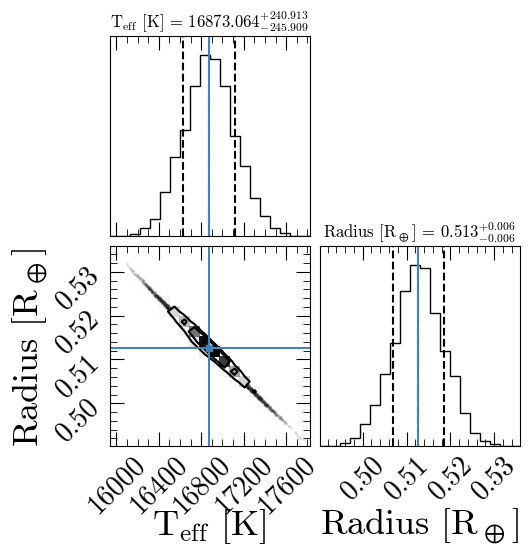

In [12]:
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\oplus]$']
best_est = np.zeros((len(labels)))
unc = []

temp_chain = gaia_chains[source_id]
temp_chain[:, 1] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(temp_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

In [13]:
from astropy.io import fits

aaa = fits.open('../data/observations/j0608m0059/j0608m0059_coadd.fits')

In [14]:
aaa[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSPYT = '3.11.8  '           / Python version                                 
VERSNPY = '1.26.4  '           / Numpy version                                  
VERSSCI = '1.12.0  '           / Scipy version                                  
VERSAST = '6.0.0   '           / Astropy version                                
VERSSKL = '1.4.1.post1'        / Scikit-learn version                           
VERSPYP = '1.15.0  '           / PypeIt version                                 
DATE    = '2024-04-01'         / UTC date created                               
RA      =    92.21208333333333 / (J2000) RA in decimal degrees                  
DEC     =  -0.99711111111111

In [15]:
### Tools
import sys
sys.path.append('../')
from corecomposition import interpolator
from corecomposition import vgsimulator

sys.path.append('../../')
import WD_models

### Constants
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da


In [16]:
# which photometric bands to interpolate onto?
bands = ['Gaia_RP', 'Gaia_BP'] 

# create interpolators from the following models with the following parameters
one_hrich = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')
co_hrich = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')

In [17]:
def rv_from_radius(radarray, teffarray):
    font_model = WD_models.load_model('f', 'Renedo2010_0001', 'ft', 'H')
    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)
    return rv*1e-3

In [18]:
# the array of radii at which to calculate vg
rad_array = np.linspace(0.0045, 0.0075, 100)
teff = 16884

rad_continued = np.linspace(0.006, 0.009, 100)
vg_array_one_hrich_ext = rv_from_radius(rad_continued, teff)
model = interpolator.LaPlataBase(bands=['Gaia_G'], layer='Hrich')

# for each model, compute gravitational redshift from the mass-radius relation
vg_array_one_hrich = newton_G * one_hrich.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_one_hdef = newton_G * one_hdef.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hrich =  newton_G * co_hrich.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hdef =  newton_G * co_hdef.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3

In [42]:
from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter
from sys import float_info



def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if (abs(entry) < float_info.epsilon) or (np.isnan(entry)):
            corrected_array[i] = float_info.epsilon
    
    return corrected_array
#def RtoM(radius):
#    return model.radiustomass(radius / 109.075, 16880)
#def MtoR(mass):
#    return model.masstoradius(mass, 16880) * 109.075

def RtoM(radarray):
    font_model = WD_models.load_model('f', 'Renedo2010_0001', 'ft', 'H')
    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray / 109.075, 16880) * mass_sun
    return mass
def MtoR(mass):
    font_model = WD_models.load_model('f', 'Renedo2010_0001', 'ft', 'H')
    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    msun_teff_to_r = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    
    radius = msun_teff_to_r(mass, 16880) * 109.075
    return mass

fig, (ax1) = plt.subplots(ncols = 1, figsize=(14, 4))

gravz = np.array([rv]) - obj['ms_rv']
e_gravz = np.sqrt(np.array([e_rv])**2 + obj['ms_erv']**2)
radius = radius_table['radius_med'].data * 109.075
e_radius = radius_table['e_radius'].data * 109.075

# plot each of the four models
ax1.plot(rad_array * 109.075, vg_array_one_hrich, c = 'k', label='O/Ne Core Composition')
#ax1.plot(rad_array * 109.075, vg_array_one_hdef, c = 'k', ls = '--')
ax1.plot(rad_array * 109.075, vg_array_co_hrich, c = 'r', label = 'C/O Core Composition')
ax1.plot(rad_continued * 109.075, vg_array_one_hrich_ext, c = 'r', ls = '--', label = 'C/O Core (Fontaine+2001)')
#ax1.plot(rad_array * 109.075, vg_array_co_hdef, c = 'r', ls = '--')
#ax1.errorbar(radius, gravz, xerr = e_radius, yerr = e_gravz, fmt = 'o', c = 'k')
ax1.scatter(radius, gravz, c = 'k', zorder=100)
for i in range(len(gravz)):
    ellipse = Ellipse((radius[i], gravz[i]), width=2*e_radius[i], height=2*e_gravz[i],
                        edgecolor='k', facecolor='none', linestyle='-', alpha = 1, zorder=100)
    ax1.add_patch(ellipse)


objs = Table.read('../data/cleaned/fa24_UVES_radius_table_warwick.csv')
for row in objs:
    ax1.axvline(x = row['radius_med'] * 109.075, c = 'k')
    #ax1.axvspan((row['radius_med'] - row['e_radius']) * 109.075,
    #            (row['radius_med'] + row['e_radius']) * 109.075,
    #              alpha=0.1, color='k')

# change the limits of the plot 
ax1.set_xlim(0.0045* 109.075, 0.008* 109.075)
ax1.set_ylim(55, 200)
#ax1.set_xlim(0.0045* 109.075, 0.008* 109.075)
#ax1.set_ylim(80, 200)
# axis labels
ax1.set_xlabel(r'Radius [$R_\oplus$]')
ax1.set_ylabel(r'$v_g$ [$kms^{-1}$]')
ax1.legend(framealpha=0)

#ax3 = ax1.secondary_xaxis('top', functions=(RtoM, MtoR))
#ax3.set_xlabel('Mass $[M_\\odot]$')
#radius_ticks = ax1.get_xticks()
#mass_ticks = RtoM(radius_ticks)
#ax3.set_xticks(mass_ticks)
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig('../figures/feasibility.pdf')

<>:80: SyntaxWarning: invalid escape sequence '\o'
<>:80: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_78870/1967170764.py:80: SyntaxWarning: invalid escape sequence '\o'
  ax3.set_xlabel('Mass $[M_\odot]$')
